<a href="https://colab.research.google.com/github/johnnyff/bigcontest2021/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head> 2021 Bigcontest - insightwo

## Module Import

### Install Module

In [ ]:
!pip install filterpy

In [ ]:
!pip install catboost

### Import Module

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import math
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import warnings
from tqdm import tqdm
warnings.filterwarnings(action='ignore') 

## Data Preprocessing

In [ ]:
#데이터 불러오기
df = pd.read_excel('./data/train.xlsx', header = 1)
#칼럼명 설정
columns = ['num','year','month','day','hour','target',
           'average_rain_1','a_rain_1','b_rain_1','c_rain_1','d_rain_1','e_level_1','d_level_1',
           'average_rain_2','a_rain_2','b_rain_2','c_rain_2','d_rain_2','e_level_2','d_level_2',
           'average_rain_3','a_rain_3','b_rain_3','c_rain_3','d_rain_3','e_level_3','d_level_3',
           'average_rain_4','a_rain_4','b_rain_4','c_rain_4','d_rain_4','e_level_4','d_level_4',
           'average_rain_5','a_rain_5','b_rain_5','c_rain_5','d_rain_5','e_level_5','d_level_5',
           'average_rain_6','a_rain_6','b_rain_6','c_rain_6','d_rain_6','e_level_6','d_level_6']
df.columns = columns

\#\#\#\#\#\#\#\#\#__데이터 수정__\#\#\#\#\#\#\#\#\#

In [ ]:
df.iloc[2196,0]=20

### year/month/day를 'hour' 칼럼에 datetime 객체로 병합

In [ ]:
import datetime as dt

for i in range(len(df)):
    year= df['year'][i]
    month= df['month'][i]
    day= df['day'][i]
    hour= df['hour'][i]
    
    if (hour == 24):
        day +=1
        hour = 0
    try:
        df['hour'][i] = dt.datetime(year, month, day, hour)
    except (ValueError):
        day = 1
        month += 1
        df['hour'][i] = dt.datetime(year, month, day, hour)

__month와 day는 drop__

In [ ]:
# 외부데이터 아무것도 없는 train_data
dataset = df.drop(['month','day'], axis =1 )

### Kalman Filter로 새 컬럼 추가

In [ ]:
for i in range(4,46):
    current=0
    sum_c=[]
    for num in range(1,27):
        z = dataset.loc[dataset.num == num, dataset.columns[i]]
        a = []           #필터링 된 피쳐(after)
        b = []           #필터링 전 피쳐(before)
        my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
        my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
        my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
        my_filter.H = np.array([[1.,0.]])    # Measurement function
        my_filter.P *= 1000.                 # covariance matrix
        my_filter.R = 5                      # state uncertainty
        my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.1) # process uncertainty   
        for k in z.values:
            my_filter.predict()
            my_filter.update(k)
            # do something with the output
            x = my_filter.x
            a.extend(x[0])
            b.append(k)
        #dataset.loc[dataset.num == num, dataset.columns[i]] = a
        sum_c=sum_c+a
    dataset.loc[:,'f'+str(i)]=sum_c
dataset.head()

,num,year,hour,target,average_rain_1,a_rain_1,b_rain_1,c_rain_1,d_rain_1,e_level_1,...,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45
0,1,2006,2006-07-10 08:00:00,189.100000,6.4,7,7,7,8,2.54,...,7.985037,2.538653,122.359102,6.389027,6.987531,6.987531,7.985037,7.985037,2.538653,122.309227
1,1,2006,2006-07-10 09:00:00,216.951962,6.3,7,8,7,8,2.53,...,10.009468,2.532692,123.228085,7.312432,7.024033,8.014347,10.009468,10.009468,2.532692,123.179826
2,1,2006,2006-07-10 10:00:00,251.424419,6.4,7,9,7,8,2.53,...,11.178264,2.530129,123.032140,8.209259,7.016413,9.010653,10.348353,11.178264,2.530129,122.985964
3,1,2006,2006-07-10 11:00:00,302.812199,7.3,7,10,7,8,2.53,...,13.607101,2.529342,122.920170,10.643673,8.409064,10.008417,13.905615,13.607101,2.529342,122.882323
4,1,2006,2006-07-10 12:00:00,384.783406,8.2,7,12,8,10,2.53,...,15.805628,2.529072,122.845374,13.521252,10.804641,11.606027,17.203117,15.805628,2.529072,122.814653


### y_수위를 다항회귀를 통해 예측되는 유입량 값으로 대체

171.6045274720825 [  0.         -77.88252507  71.90788562]


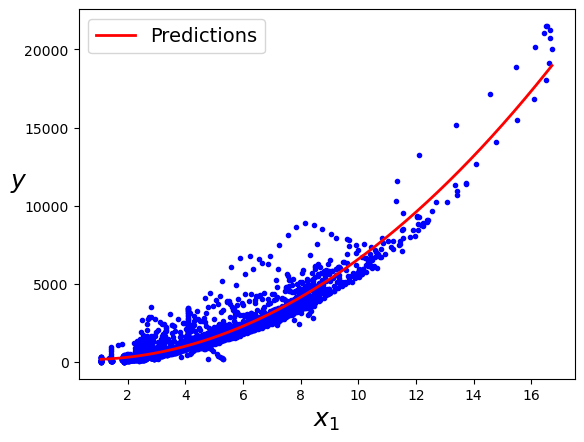

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly_features.fit_transform(np.array(df['e_level_1']).reshape(-1,1))


lin_reg = LinearRegression()
lin_reg.fit(X_poly[:-160], np.array(df['target'][:-160]))
print(lin_reg.intercept_ , lin_reg.coef_)


X_new=np.linspace(df['e_level_1'][:-160].min(), df['e_level_1'][:-160].max(), len(df['e_level_1'][:-160])).reshape(-1,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(df['e_level_1'][:-160], df['target'][:-160], "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()

In [ ]:
temp = poly_features.transform(np.array(dataset['e_level_1']).reshape(-1,1))
dataset['e_level_1'] = lin_reg.predict(temp)

### delay 1 hour / 2 hour

In [ ]:
k_list=[1,2]  #밀고 싶은 칸 수
col_list=['average_rain','a_rain','b_rain','c_rain','d_rain','e_level','d_level']
for k in tqdm(k_list):
    for col in tqdm(col_list):
        now=0   #건드리면 안됨!
        current=-1  #건드리면 안됨!
        for i in range(3051):
            if int(now/k) == dataset.loc[i,'num']:
                dataset.loc[i,col+'_1_d_'+str(k)]=dataset.loc[i-k,col+'_1']
                dataset.loc[i,col+'_2_d_'+str(k)]=dataset.loc[i-k,col+'_2']
                dataset.loc[i,col+'_3_d_'+str(k)]=dataset.loc[i-k,col+'_3']
                dataset.loc[i,col+'_4_d_'+str(k)]=dataset.loc[i-k,col+'_4']
                dataset.loc[i,col+'_5_d_'+str(k)]=dataset.loc[i-k,col+'_5']
                dataset.loc[i,col+'_6_d_'+str(k)]=dataset.loc[i-k,col+'_6']
                current=i
            else:
                dataset.loc[i,col+'_1_d_'+str(k)]=dataset.loc[current+1,col+'_1']
                dataset.loc[i,col+'_2_d_'+str(k)]=dataset.loc[current+1,col+'_2']
                dataset.loc[i,col+'_3_d_'+str(k)]=dataset.loc[current+1,col+'_3']
                dataset.loc[i,col+'_4_d_'+str(k)]=dataset.loc[current+1,col+'_4']
                dataset.loc[i,col+'_5_d_'+str(k)]=dataset.loc[current+1,col+'_5']
                dataset.loc[i,col+'_6_d_'+str(k)]=dataset.loc[current+1,col+'_6']
                now=now+1

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:42<00:00, 21.10s/it]


### 1시간 / 2시간 동안의 변화량 구하기 

In [ ]:
for col in dataset.columns[4:46]:
    c1 = col+'_d_1'
    c2 = col+'_d_2'
    dataset[c1] = dataset[col]-dataset[c1]+0.1
    dataset[c2] = dataset[col]-dataset[c2]+0.1

### Test Set 분리

In [ ]:
test_data = dataset[-160:]
train_data = dataset[:-160]

In [ ]:
train_data_c=train_data.copy()

### 각 사상별 target 상위, 하위 1프로씩 제거 (이상치제거)

In [ ]:
for num in range(1,26):
    z = train_data.loc[train_data.num == num,:]

    quartile_1 = z['target'].quantile(0.01)
    quartile_2 = z['target'].quantile(0.99)

    search_df = z[(z['target'] < quartile_1) | (z['target'] > quartile_2)]
    #print("삭제하는 데이터 인덱스: ",search_df.index)
    train_data = train_data.drop(search_df.index, axis=0)

### 미사용 Features Drop

In [ ]:
train_data = train_data.drop(['hour','num'], axis = 1)
train_data_c = train_data_c.drop(['hour','num'], axis = 1)
test_data = test_data.drop(['hour','num'], axis=1)

## Train & Validation

### K-Fold Validation

___test를 각 사상별1~25으로 반복수행, target값이 치우쳐져 있어서 log씌움(예측값에 다시 exp 해줌, 각 사상별 target 분포 eda에 추가해야함), result는 각 사상을 test로 했을 때 rmse값___

In [ ]:
#사상별 index
start_index=[0,226,326,407,441,535,581,632,673,741,827,937,1064,1131,1181, 1443, 1648, 1773, 1838, 1933, 2196, 2281, 2566, 2694, 2788]
finish_index=[226,326,407,441,535,581,632,673,741,827,937,1064,1131,1181, 1443, 1648, 1773, 1838, 1933, 2196, 2281, 2566, 2694, 2788,2890]

In [ ]:
def validation_check(df, df_c, indices):
    '''indices의 사상으로 validation 진행한 뒤 결과 반환'''
    
    from catboost import CatBoostRegressor

    result=[]
    count=0
    for i in indices:
        rmse=0
        model_cat = CatBoostRegressor(iterations=2000, l2_leaf_reg = 0.003, random_seed = 1422)

        tmp1=df.loc[start_index[i]:finish_index[i]].drop(['target'], axis =1 )  
        tmp2=df.loc[start_index[i]:finish_index[i],'target']

        X_train=df.drop(index=tmp1.index).drop(['target'], axis =1 )
        try:
            X_train=X_train.drop(['num'], axis =1 )
        except:
            pass
        y_train=df.drop(index=tmp2.index).loc[:,'target']

        X_test=df_c.loc[start_index[i]:finish_index[i]].drop(['target'], axis =1 )
        try:
            X_test=X_test.drop(['num'], axis =1 )
        except:
            pass
        y_test=df_c.loc[start_index[i]:finish_index[i],'target']

        y_train=np.log1p(y_train)

        model_cat.fit(X_train,y_train)
        preds_cat = model_cat.predict(X_test)
        preds_cat=np.expm1(preds_cat)
        rmse=mean_squared_error(preds_cat, y_test) ** 0.5
        result.append(rmse)
        count=count+1
        print('************now ',count,' finished***********')
    
    return result

#### train_data (Default)

In [ ]:
result = validation_check(train_data, train_data_c, list(range(25)))

0:	learn: 1.1376576	total: 174ms	remaining: 5m 47s
1:	learn: 1.1113338	total: 187ms	remaining: 3m 6s
2:	learn: 1.0855290	total: 200ms	remaining: 2m 13s
3:	learn: 1.0587976	total: 214ms	remaining: 1m 46s
4:	learn: 1.0334881	total: 228ms	remaining: 1m 30s
5:	learn: 1.0087023	total: 240ms	remaining: 1m 19s
6:	learn: 0.9853124	total: 254ms	remaining: 1m 12s
7:	learn: 0.9619070	total: 266ms	remaining: 1m 6s
8:	learn: 0.9394162	total: 279ms	remaining: 1m 1s
9:	learn: 0.9169218	total: 292ms	remaining: 58.2s
10:	learn: 0.8960228	total: 306ms	remaining: 55.3s
11:	learn: 0.8741796	total: 328ms	remaining: 54.3s
12:	learn: 0.8535055	total: 380ms	remaining: 58s
13:	learn: 0.8332890	total: 402ms	remaining: 57.1s
14:	learn: 0.8140550	total: 419ms	remaining: 55.4s
15:	learn: 0.7953402	total: 432ms	remaining: 53.5s
16:	learn: 0.7776776	total: 446ms	remaining: 52s
17:	learn: 0.7610584	total: 459ms	remaining: 50.5s
18:	learn: 0.7451430	total: 472ms	remaining: 49.2s
19:	learn: 0.7283182	total: 485ms	remai

In [ ]:
result

[2909.56389371291,
 840.400747552113,
 438.8796675792989,
 367.6393251316601,
 1116.7028000945488,
 232.4089781827775,
 710.2214500148465,
 861.3610755314774,
 357.4109468353351,
 234.78061359106235,
 407.74845434555306,
 339.2141061019587,
 310.2217623465829,
 471.86799685436887,
 315.55370118582243,
 312.5858899975527,
 426.27883753727923,
 530.4768600795812,
 159.54385574036795,
 190.37450104119833,
 515.5424981756258,
 267.37832687165337,
 678.5220722220336,
 506.0065823842164,
 171.24626287101404]

In [ ]:
np.mean(result)

546.8772482392335

### 모델 학습

In [ ]:
from catboost import CatBoostRegressor
model_cat = CatBoostRegressor(iterations=100, l2_leaf_reg = 0.003, random_seed = 1422)

X_train=train_data.drop(['target'], axis =1 )
y_train=train_data['target']
y_train=np.log1p(y_train)
X_test=test_data.drop(['target'], axis=1)

model_cat.fit(X_train,y_train)

0:	learn: 1.1677554	total: 16.7ms	remaining: 1.65s
1:	learn: 1.1391679	total: 39.4ms	remaining: 1.93s
2:	learn: 1.1105831	total: 72.5ms	remaining: 2.34s
3:	learn: 1.0848753	total: 96.2ms	remaining: 2.31s
4:	learn: 1.0580245	total: 125ms	remaining: 2.38s
5:	learn: 1.0328634	total: 145ms	remaining: 2.27s
6:	learn: 1.0088838	total: 177ms	remaining: 2.35s
7:	learn: 0.9844319	total: 204ms	remaining: 2.35s
8:	learn: 0.9600173	total: 221ms	remaining: 2.24s
9:	learn: 0.9368262	total: 239ms	remaining: 2.15s
10:	learn: 0.9148612	total: 254ms	remaining: 2.05s
11:	learn: 0.8930254	total: 268ms	remaining: 1.96s
12:	learn: 0.8718182	total: 280ms	remaining: 1.88s
13:	learn: 0.8510286	total: 298ms	remaining: 1.83s
14:	learn: 0.8319728	total: 323ms	remaining: 1.83s
15:	learn: 0.8128466	total: 343ms	remaining: 1.8s
16:	learn: 0.7941561	total: 357ms	remaining: 1.74s
17:	learn: 0.7768621	total: 371ms	remaining: 1.69s
18:	learn: 0.7600648	total: 384ms	remaining: 1.64s
19:	learn: 0.7425829	total: 398ms	rema

## 결과

### 26번 사상 예측값 출력

In [ ]:
pred26 = model_cat.predict(X_test)
pred26=np.expm1(pred26)

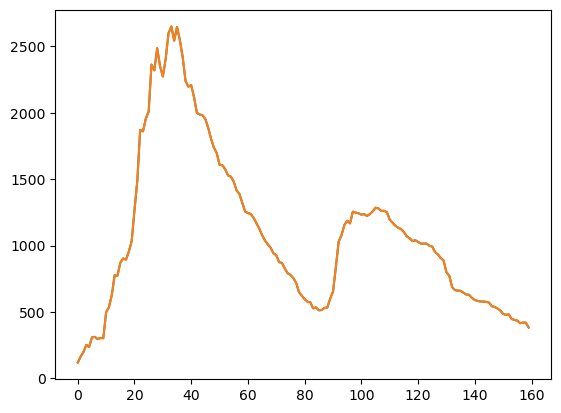

In [ ]:
plt.plot(pred26)
plt.show()

In [ ]:
for pred in pred26:
    print(pred)

119.82908498195296
163.32505731343227
198.506566710134
252.3934955656649
237.24592070712174
308.47691250354694
312.8572174923082
295.85075878941205
303.95422508991066
302.62709914784415
498.2042233847242
537.1697431156933
627.4515769065105
776.1036376415886
773.7439557477207
870.8206074043867
903.05153202389
894.1041294433838
954.356379602116
1031.7546157686766
1266.8213364966305
1488.3018315081488
1871.2171229654627
1860.0744640577113
1956.0843248461408
2008.990006034625
2363.18289040032
2319.430164447514
2486.7528842626407
2352.16610465388
2273.2307604379384
2405.32037984744
2598.745228148132
2650.056912983431
2543.265557699859
2646.5731551599088
2547.264765062323
2418.6822797492196
2239.7213948147155
2196.773044021707
2207.510986022582
2117.3484274556263
1999.9550047173861
1986.836724457552
1981.8918458316043
1952.4846652788735
1886.3689390287475
1804.593193689903
1737.9940141148895
1697.5160431307265
1608.516664623964
1604.8730642071168
1574.580890693517
1528.0770363034992
1519.183